# Benchmark model

The purpose of this notebook is to benchmark persisted onnx-model (trained in the
previous step) against evaluation set.

### Determine run parameters

In [1]:
# ----------------- Parameters for interactive development --------------
P = {
    "pipeline.data_lake_root": "/pipeline-outputs/data-lake",
    "task.nr_train_images": 600,
}

In [2]:
# - During automated runs parameters will be injected in the below cell -

In [3]:
# Parameters
P = {
    "pipeline.data_lake_root": "/pipeline-outputs/data-lake",
    "pipeline.run_environment": "ci",
    "pipeline.pipeline_run_id": "bf2e3d2c-c43f-41c7-942f-3f58890d3649",
    "pipeline.github.repository": "matiasdahl/dev-mnist-digits-demo-pipeline",
    "pipeline.github.workflow": "Run automated tests, pipeline and deploy results to static reporting site",
    "pipeline.github.runner_name": "Hosted Agent",
    "pipeline.github.run_id": "3627132107",
    "pipeline.github.actor": "matiasdahl",
    "pipeline.github.job": "run-tests-pipeline-and-persist-pipeline-outputs",
    "pipeline.github.base_ref": "",
    "pipeline.github.head_ref": "",
    "pipeline.github.sha": "ace0d01011d5e914f1921450dd5a59c11367b38d",
    "pipeline.github.ref": "refs/heads/development",
    "pipeline.github.ref_type": "branch",
    "pipeline.github.ref_name": "development",
    "pipeline.github.event_name": "schedule",
    "task.nr_train_images": 800,
    "task.notebook": "notebooks/benchmark-model.py",
    "task.max_nr_retries": "1",
    "run.retry_nr": "0",
    "task.timeout_s": "None",
    "task.num_cpus": 1,
    "_opentelemetry_traceparent": "00-fc58cfcfae3a12f61dcf247fa53287f2-3aa19bd4d5edc385-01",
}


In [4]:
# -----------------------------------------------------------------------

---

### Notebook code

In [5]:
import itertools as it

#
import numpy as np
import matplotlib.pyplot as plt

#
from pynb_dag_runner.tasks.task_opentelemetry_logging import PydarLogger

#
from common.io import datalake_root

logger = PydarLogger(P)

2022-12-06 06:43:17,700	INFO worker.py:842 -- Connecting to existing Ray cluster at address: 172.17.0.2:6379


## Load persisted onnx-model and evaluation data

In [6]:
from common.io import read_onnx, get_onnx_inputs, get_onnx_outputs, read_numpy

In [7]:
onnx_inference_session = read_onnx(
    datalake_root(P)
    / "models"
    / f"nr_train_images={P['task.nr_train_images']}"
    / "model.onnx"
)

### Record structure of inputs and outputs for ONNX model

(this should likely be done in training notebook)

In [8]:
import json

onnx_io = json.dumps(
    {
        "inputs": get_onnx_inputs(onnx_inference_session),
        "outputs": get_onnx_outputs(onnx_inference_session),
    },
    indent=2,
)


logger.log_artefact("onnx_io_structure.json", onnx_io)
print(onnx_io)

{
  "inputs": [
    {
      "name": "float_input_8x8_image",
      "shape": [
        null,
        64
      ],
      "type": "tensor(float)"
    }
  ],
  "outputs": [
    {
      "name": "output_label",
      "shape": [
        null
      ],
      "type": "tensor(int64)"
    },
    {
      "name": "output_probability",
      "shape": [],
      "type": "seq(map(int64,tensor(float)))"
    }
  ]
}


### Evaluate model performance on evaluation data set

In [9]:
# load evaluation data
X_test = read_numpy(datalake_root(P) / "test-data" / "digits.numpy")
y_test = read_numpy(datalake_root(P) / "test-data" / "labels.numpy")

In [10]:
def get_model_outputs(X, onnx_inference_session):
    y_pred_labels, y_pred_map = onnx_inference_session.run(
        ["output_label", "output_probability"],
        {"float_input_8x8_image": X.astype(np.float32)},
    )
    y_pred_probs = np.array(
        [[probabilities[digit] for digit in range(10)] for probabilities in y_pred_map]
    )

    assert y_pred_labels.shape == (X.shape[0],)
    assert y_pred_probs.shape == (X.shape[0], 10)

    return y_pred_labels, y_pred_probs


# Note: as shown in the training notebook, the predicted labels and probabilities
# computed below need not be compatible.
y_pred_labels_test, y_pred_probs_test = get_model_outputs(
    X_test, onnx_inference_session
)

### Confusion matrix

In [11]:
# TODO

### Plot predicted probabilities for each classifier over all evaluation digit images

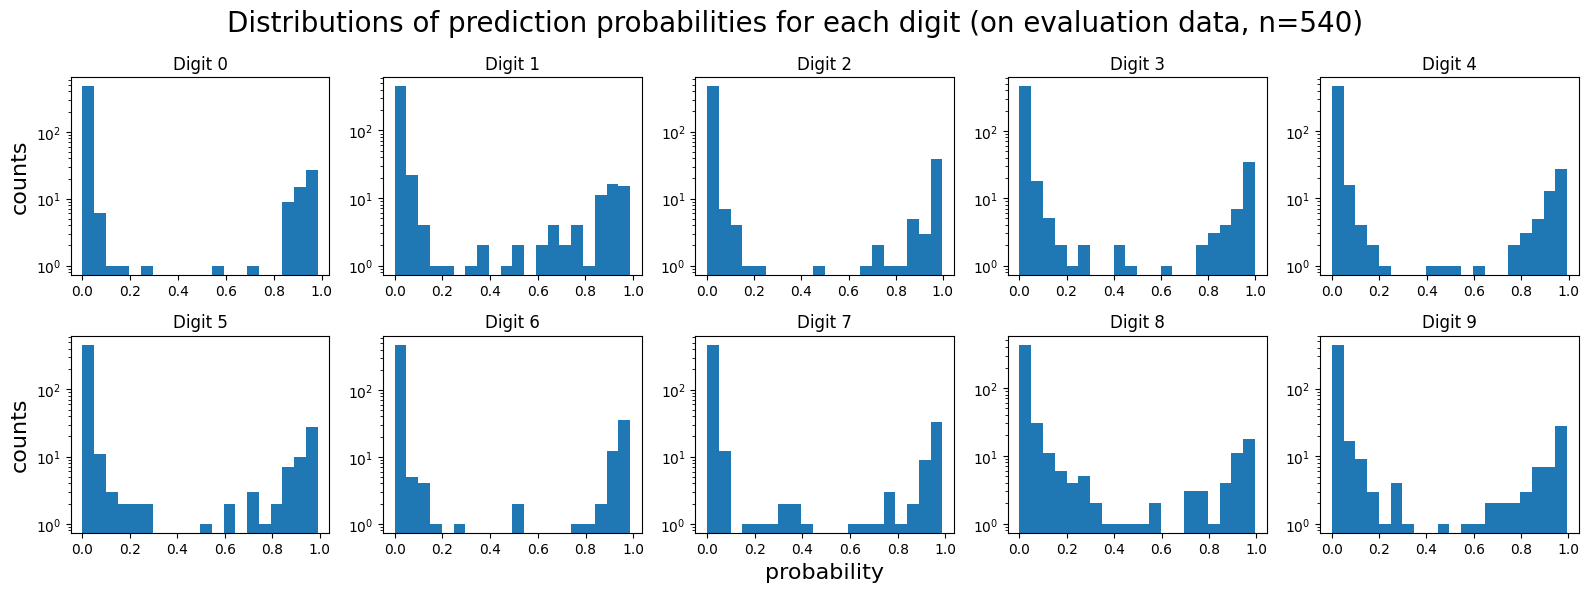

In [12]:
def plot_per_digit_probabilities(y_pred_probs):
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))

    for (r, c), digit, ax in zip(
        it.product(range(2), range(5)), range(10), axs.reshape(-1)
    ):
        ax.hist(y_pred_probs_test[:, digit], bins=20)

        ax.set_title(f"Digit {digit}")
        if r == 1 and c == 2:
            ax.set_xlabel("probability", fontsize=16)

        if c == 0:
            ax.set_ylabel("counts", fontsize=16)
        ax.set_yscale("log")

    fig.tight_layout()
    fig.suptitle(
        f"Distributions of prediction probabilities for each digit "
        f"(on evaluation data, n={y_pred_probs.shape[0]})",
        fontsize=20,
    )
    fig.tight_layout()
    fig.show()

    return fig


fig = plot_per_digit_probabilities(y_pred_probs_test)

From the above distributions we see that most digits have clear separation between
high and lower probabilities. Morover, in each case there is roughly an order of
magnitude more of digits with low probabilities. This is compatible with digits
being roughly evenly distributed in the data.

In [13]:
logger.log_figure("per-digit-probabilities.png", fig)

### Plot ROC curves for individual one-vs-rest classifiers

In [14]:
from sklearn import metrics

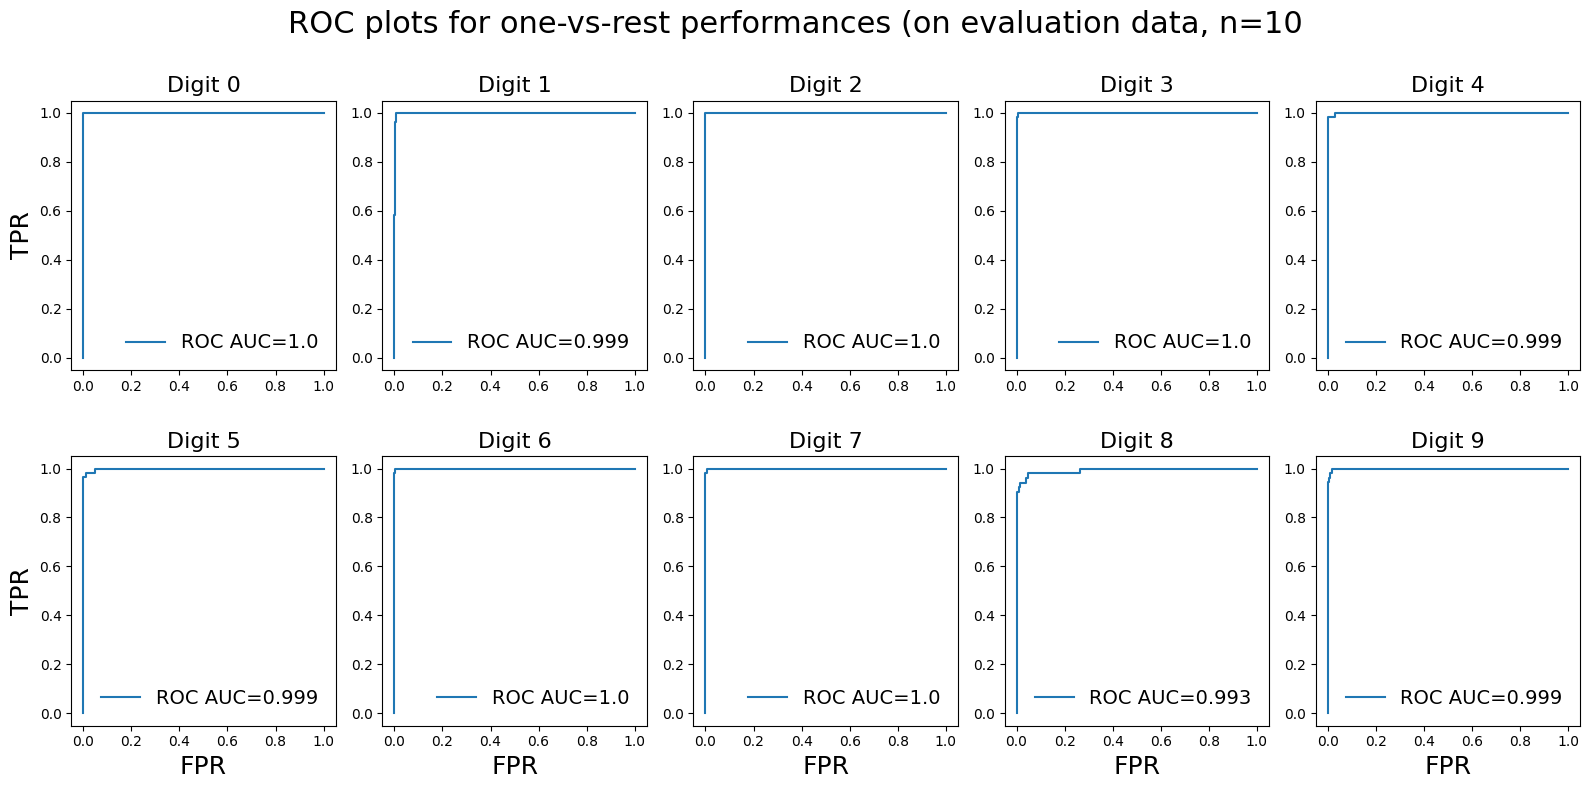

In [15]:
def plot_roc_curves(y, y_pred_probs):
    # based on example code
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))

    roc_auc_dict = {}

    for (r, c), digit, ax in zip(
        it.product(range(2), range(5)), range(10), axs.reshape(-1)
    ):
        fpr, tpr, _ = metrics.roc_curve(y == digit, y_pred_probs[:, digit])
        auc = metrics.auc(fpr, tpr)
        roc_auc_dict[str(digit)] = auc

        ax.plot(fpr, tpr, label=f"ROC AUC={round(auc, 3)}")

        ax.set_title(f"\nDigit {digit}", fontsize=16)
        if r == 1:
            ax.set_xlabel("FPR", fontsize=18)

        if c == 0:
            ax.set_ylabel("TPR", fontsize=18)

        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])
        ax.legend(loc="lower right", frameon=False, fontsize=14)

    fig.tight_layout()
    fig.suptitle(
        f"ROC plots for one-vs-rest performances "
        f"(on evaluation data, n={y_pred_probs_test.shape[1]}",
        fontsize=22,
    )
    fig.tight_layout()
    fig.show()

    return roc_auc_dict, fig


roc_auc_dict, fig = plot_roc_curves(y_test, y_pred_probs_test)

In [16]:
logger.log_figure("per-digit-roc-curves.png", fig)

In [17]:
roc_auc_dict

{'0': 1.0,
 '1': 0.9988003748828491,
 '2': 1.0,
 '3': 0.9998125585754452,
 '4': 0.9994665447340345,
 '5': 0.998950328022493,
 '6': 0.999961896052431,
 '7': 0.9998856881572931,
 '8': 0.9928672761664564,
 '9': 0.9994284407864654}

In [18]:
logger.log_value("roc_auc_per_digit", roc_auc_dict)

 - Logging roc_auc_per_digit (json) : {'0': 1.0, '1': 0.9988003748828491, '2': 1.0, '3': 0.9998125585754452, '4': 0.9994665447340345, '5': 0.998950328022493, '6': 0.999961896052431, '7': 0.9998856881572931, '8': 0.9928672761664564, '9': 0.9994284407864654}


### Compute and log mean ROC AUC score averaged over all digits

In [19]:
roc_auc_macro = np.mean(list(roc_auc_dict.values()))

logger.log_float("roc_auc_class_mean", roc_auc_macro)

# assert that the same value can be computed directly using sklearn
assert roc_auc_macro == metrics.roc_auc_score(
    y_test, y_pred_probs_test, average="macro", multi_class="ovr"
)

 - Logging roc_auc_class_mean (float) : 0.9989173107377468


In [20]:
# ---